# OBIA Solar Panel Segmentation using `nickyspatial`

## 1. Segment on nickyspatial
Note: If the image is too big, downsample the image. The code to downsample the image is at last of this notebook. 

### 1.1. Define Segmentation

In [7]:
import os
import numpy as np
from nickyspatial import (
    LayerManager,
    read_raster,
    SlicSegmentation,
    plot_layer 
)

def run_slic_segmentation(raster_path, output_dir, scale=40.0, compactness=0.5):
    """
    Runs OBIA segmentation using SLIC on a given raster and saves the output image.

    Parameters:
        raster_path (str): Path to the input raster image.
        output_dir (str): Directory where the output image will be saved.
        scale (float): Scale parameter for SLIC segmentation.
        compactness (float): Compactness parameter for SLIC segmentation.
    """
    # Step 1: Read raster
    print(f"Reading raster from: {raster_path}")
    image_array, transform, crs = read_raster(raster_path)
    print(f"Original image shape: {image_array.shape} (bands, height, width)")
    print(f"CRS: {crs}")

    # Step 2: OBIA segmentation
    print("Running OBIA segmentation using SlicSegmentation...")
    manager = LayerManager()
    segmenter = SlicSegmentation(scale=scale, compactness=compactness)

    segmentation_layer = segmenter.execute(
        image_array,
        transform,
        crs,
        layer_manager=manager,
        layer_name="Solar_OBIA_Segments"
    )

    print("Segmentation complete.")
    print(segmentation_layer)

    # Step 3: Prepare RGB image for visualization
    image_array_rgb = np.moveaxis(image_array, 0, -1)  # (bands, H, W) → (H, W, bands)
    if image_array_rgb.max() > 1:
        image_array_rgb = image_array_rgb / 255.0

    # Step 4: Validate dimensions
    seg = segmentation_layer.raster
    print(f"Segmentation shape: {seg.shape}, Image shape: {image_array_rgb.shape[:2]}")

    if seg.shape != image_array_rgb.shape[:2]:
        raise ValueError("Mismatch between segmentation and image dimensions.")

    # Step 5: Plot using NickySpatial’s plot_layer
    print("Plotting segmentation overlay using plot_layer from NickySpatial...")

    # plot only 3 bands of the multispectral image. RGB image does not need this.
    seg_h, seg_w = segmentation_layer.raster.shape
    image_array_rgb = image_array[:3, :seg_h, :seg_w]  # shape: (3, H, W)
    
    print(f"Final RGB shape: {image_array_rgb.shape}, Segmentation shape: {segmentation_layer.raster.shape}")

    fig = plot_layer(
        layer=segmentation_layer,
        image_data=image_array_rgb,
        show_boundaries=True,
        title="SLIC Segmentation Overlaid on Ortho",
        figsize=(10, 10)
    )

    # Step 6: Save the figure
    output_path = os.path.join(output_dir, "slic_segments.png")
    fig.savefig(output_path, dpi=150)
    print(f"Segmentation overlay saved at: {output_path}")

    return segmentation_layer


### 1.2. Run Segmentation

Reading raster from: ortho/solar_pv_True_Ortho_downsampled.tif
Original image shape: (3, 5571, 3142) (bands, height, width)
CRS: PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Running OBIA segmentation using SlicSegmentation...
Number of segments: 43760
Segmentation complete.
Layer 'Solar_OBIA_Segments' (type: segmentation, parent: None, objects: 24427)
Segmentation shape: (5571, 3142), Image shape: (5571, 3142)
Plotting segmentation overlay using plot_layer from NickySpatial...
Final RGB shape: (3, 5571, 3142), Segmentation shape: (5571, 3142)
Segmen

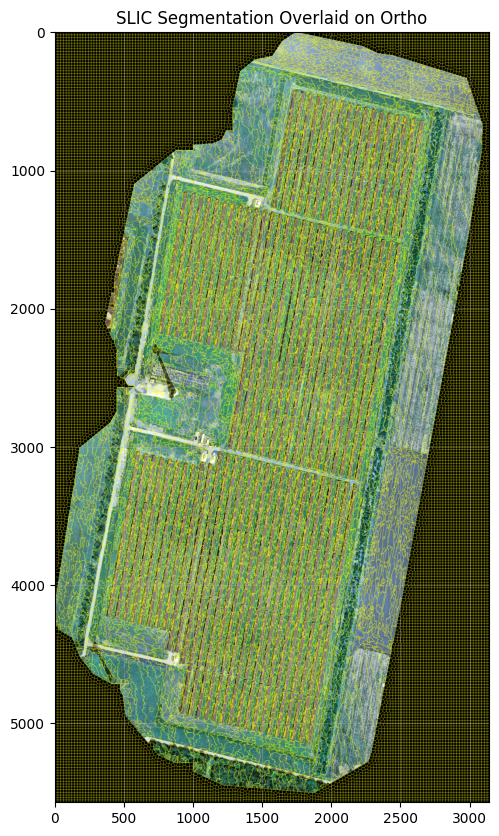

In [9]:
segmentation_layer = run_slic_segmentation(
    raster_path="ortho/solar_pv_True_Ortho_downsampled.tif",
    output_dir="results",
    scale= 20.0,
    compactness=0.5
)

## Register indices to objects

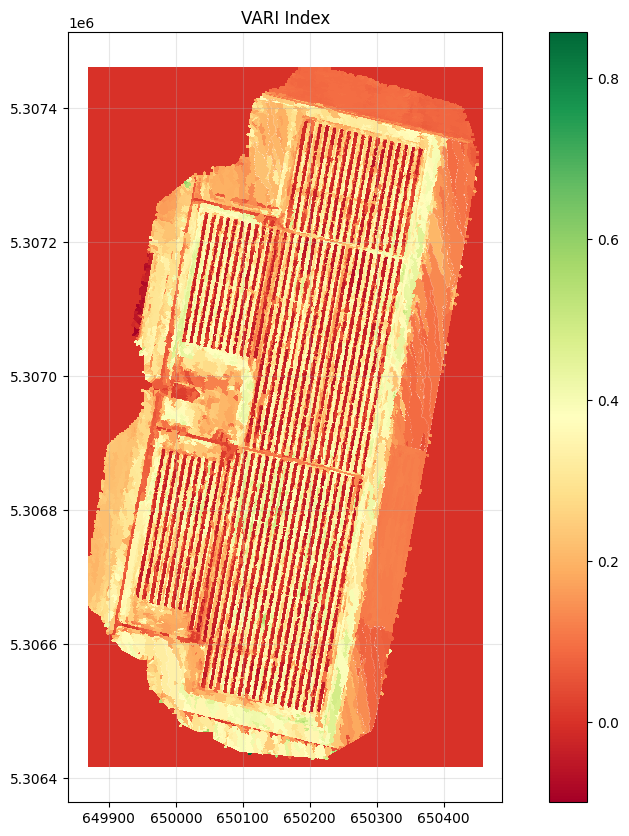

In [10]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

from nickyspatial import (
    Layer,
    LayerManager,
    RuleSet,
    read_raster,
    attach_shape_metrics,
    attach_spectral_indices,
    attach_ndvi,  # Used here to compute VARI
    plot_layer,
    plot_classification,
    layer_to_vector,
    layer_to_raster,
)

# --- Step 1: Setup paths ---
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

raster_path = "ortho/small_area_downsampled.tif"
geojson_path = "results/segment.geojson"

# --- Step 2: Load raster ---
image_array, transform, crs = read_raster(raster_path)

# --- Step 4: Add to manager ---
manager = LayerManager()
manager.add_layer(segmentation_layer)

# --- Step 5: Attach metrics ---
# segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")
# print(segmentation_layer.objects)
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")
# print(segmentation_layer.objects["area_pixels"].describe())


# Attach spectral means (needed for VARI and other indices)
segmentation_layer.attach_function(
    attach_spectral_indices,
    name="spectral_indices",
    bands={
        "blue": "band_1_mean",   # Band 1 = Blue
        "green": "band_2_mean",  # Band 2 = Green
        "red": "band_3_mean",    # Band 3 = Red
    }
)

# Reuse `attach_ndvi` to compute VARI = (G - R) / (G + R)
segmentation_layer.attach_function(
    attach_ndvi,
    name="vari_stats",
    nir_column="band_2_mean",  # Green
    red_column="band_3_mean",  # Red
    output_column="VARI"
)

# --- Optional: Visualize VARI ---
fig = plot_layer(segmentation_layer, attribute="VARI", title="VARI Index", cmap="RdYlGn")
plt.show()
# fig.savefig(os.path.join(output_dir, "1_vari.png"))

## 3. Rule Based Classification

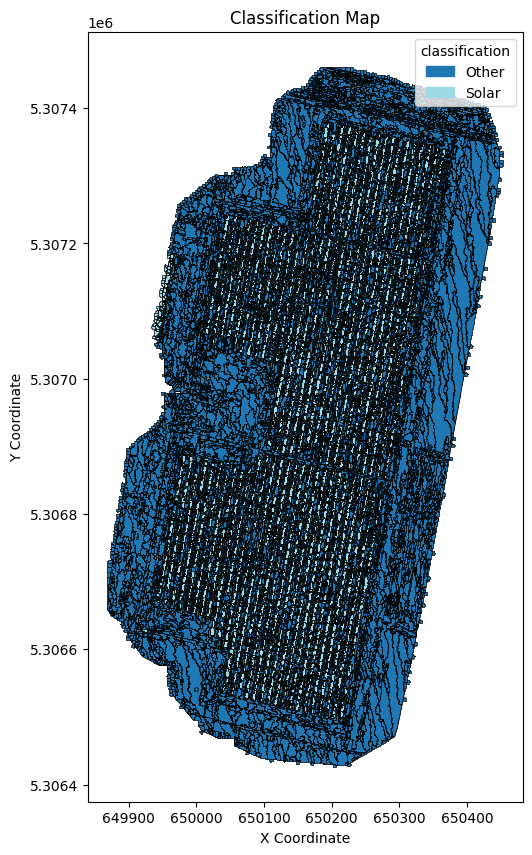

 Classification complete. Results saved to 'results/' folder.


In [11]:

rules = RuleSet(name="Test_Classification")
rules.add_rule(
    name="Solar", 
    condition="VARI <0"
)
rules.add_rule(name="Other", condition="VARI > 0")

classified_layer = rules.execute(
    segmentation_layer,
    layer_manager=manager,
    layer_name="Classified_Layer",
    result_field="classification"
)

# --- Step 7: Visualize and save ---
fig = plot_classification(classified_layer, class_field="classification")
plt.show()
# fig.savefig(os.path.join(output_dir, "2_classified.png"))

# layer_to_vector(classified_layer, os.path.join(output_dir, "classified.geojson"))
# layer_to_raster(classified_layer, os.path.join(output_dir, "classified.tif"), column="classification")

print(" Classification complete. Results saved to 'results/' folder.")


## Export Segments and Classification to Geojson

In [6]:
from copy import deepcopy
from nickyspatial import layer_to_vector

# Export segmentation layer to GeoJSON
def export_layer(layer, path):
    # Step 1: Make a deep copy of the segmentation layer
    export_layer = deepcopy(layer)
    
    # Step 2: Reproject the copied layer's GeoDataFrame
    export_layer.objects = export_layer.objects.to_crs(epsg=4326)
    
    # Step 3: Set the copied layer's CRS metadata
    export_layer.crs = "EPSG:4326"
    
    # Step 4: Export to GeoJSON for leaflet map
    
    layer_to_vector(export_layer, output_path = path)
    print(f"Reprojected GeoJSON saved to: {path}")



In [13]:
segmentation_path = "results/segment.geojson"
classified_path = "results/classified_rule_based.geojson"
export_layer(segmentation_layer, segmentation_path)
export_layer(classified_layer, classified_path)

Reprojected GeoJSON saved to: results/segment.geojson
Reprojected GeoJSON saved to: results/classified_rule_based.geojson


## Pick Samples for Supervised Classification in Map

In [1]:
# Download the whole folder: https://github.com/kshitijrajsharma/nickyspatial/tree/master/class_samples 
# Now, to open the leaflet map, follow the steps below. open terminal and goto the folder. You need to be on the same folder where this downloaded index.html is. Otherwise use --directory folder_name and update file paths in main.js

In [8]:
!start cmd /k python -m http.server 8001

In [9]:
import webbrowser
webbrowser.open("http://localhost:8001/index.html")

True

In [6]:
# If you have index.html and results folder on the same folder and inside results folder: segment.geojson file, it will automatically pull the segment.geojson. Otherwise follow these steps to upload geojson.
# you can upload geojson file or relative path of your segmentation geojson file. 
# You can also upload small image file
# go to next tab to start adding the samples. 
# 1. First choose number of classes
# 2. Give class names in input fields for each class
# 3. select class in radio button and start selecting samples in the map. you will see the segment_id of the selected sample will be added on the list on the right. 
# 4. Continue this for other classes. dont forget to select radio before the classname before selecting samples in map
# 5. After samples are collected, click Download Class Values button to download json file with the list of samples with classnames.
# 6. Copy and paste this json in your result folder. By pasting in result folder, you can directly use this file to load or copy paste values from this file to use it for classification. 

True

In [31]:
# In case your image is big and browser hangs, you have to create tiles using gdal2tiles. create those tiles first.

# then, go to folder inside tiles
# cd tiles
# python -m http.server 8000
# or
!start cmd /k python -m http.server 8000 --directory ortho/tiles

# Then you can paste your tile url: http://localhost:8000/{z}/{x}/{-y}.png in the map. It will open the tiles in the map.

In [ ]:
# After you have the list of samples. Run the classification

## 5. ML based classification

### 5.1. RandomForest

In [1]:
import os
import json
import geopandas as gpd
from nickyspatial.core.layer import Layer, LayerManager
from nickyspatial.core.classifier import SupervisedClassifier
from nickyspatial import plot_classification
import matplotlib.pyplot as plt

def classify_segments_from_file(
    segment_geojson_path,
    samples_json_path=None,
    samples_dict=None,
    classifier_type="Random Forest",
    classifier_params=None,
    output_layer_name="Solar_Only_Classification",
    class_field="classification",
    show_plot=True
):
    """
    Performs supervised classification on a GeoJSON segment layer using sample IDs.

    Parameters:
        segment_geojson_path (str): Path to the GeoJSON file containing segment objects.
        samples_json_path (str): Path to a JSON file with sample IDs (optional if samples_dict is given).
        samples_dict (dict): Dictionary of labeled sample IDs (e.g. { "Solar": [...], "Non-Solar": [...] }).
        classifier_type (str): Type of classifier to use (default is "Random Forest").
        classifier_params (dict): Parameters for the classifier (default is RF with 100 trees).
        output_layer_name (str): Name of the result layer.
        class_field (str): Name of the classification field in the output.
        show_plot (bool): Whether to show the classification plot.
    
    Returns:
        result_layer: Classified Layer object
        accuracy (float): Classification accuracy
        feature_importances (DataFrame or None)
    """
    # Load segment GeoJSON
    gdf = gpd.read_file(segment_geojson_path)

    # Load sample IDs
    if samples_dict is None:
        if samples_json_path is None:
            raise ValueError("Either samples_dict or samples_json_path must be provided.")
        with open(samples_json_path, "r", encoding="utf-8") as f:
            samples_dict = json.load(f)

    # Setup Layer and Manager
    layer = Layer(name="SegmentLayer", type="segmentation")
    layer.objects = gdf
    manager = LayerManager()
    manager.add_layer(layer)

    # Classifier parameters
    if classifier_params is None:
        classifier_params = {"n_estimators": 100, "oob_score": True, "random_state": 42}

    classifier = SupervisedClassifier(
        name="SolarClassifier",
        classifier_type=classifier_type,
        classifier_params=classifier_params
    )

    # Perform classification
    result_layer, accuracy, feature_importances = classifier.execute(
        source_layer=layer,
        samples=samples_dict,
        layer_manager=manager,
        layer_name=output_layer_name
    )

    # Plot result
    if show_plot:
        fig = plot_classification(result_layer, class_field=class_field)
        plt.show()

    print("Classification Accuracy:", accuracy)
    if feature_importances is not None:
        print("Top Features:\n", feature_importances.head())

    return result_layer, accuracy, feature_importances


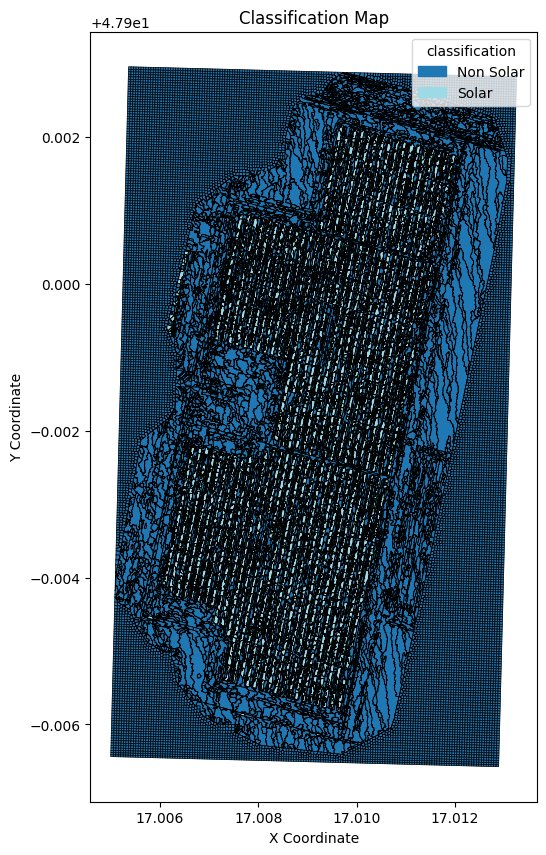

Classification Accuracy: 1.0
Top Features:
 VARI             22.229228
band_3_mean      15.421531
band_3_median    14.930974
band_2_mean       9.491023
band_2_median     7.575158
dtype: float64


In [2]:
result_layer_RF, _, _ = classify_segments_from_file(
    segment_geojson_path="results/segment.geojson",
    samples_json_path="results/samples.json", #you can either pass directly downloaded json or copy-paste the dictionary values inside file below.
    # samples_dict={
    #     "Solar": [1855, 2177, 2448, 3407, 3636, 3733, 3793, 4728,3045, 4748, 4850, 6157, 6337, 4116, 5951, 5590],
    #     "Non-Solar": [7769, 5981, 5899, 3922, 8908, 9619, 1513, 2104, 3961, 2179, 4247, 8643, 2357, 2738, 5192, 6280, 7797, 8122, 8314, 8406, 8489, 8781, 298, 5283, 7449, 8611, 9102, 9353, 9430, 10287, 9809],
    # }
)

In [7]:
classified_RF_path = "results/classified_RF_wgs84.geojson"
export_layer(result_layer_RF, classified_RF_path)

Reprojected GeoJSON saved to: results/classified_RF_wgs84.geojson


### 5.2. SVM

In [10]:
import json
import geopandas as gpd
from nickyspatial.core.layer import Layer, LayerManager
from nickyspatial.core.classifier import SupervisedClassifier
from nickyspatial import plot_classification

def run_svm_classification(
    segment_geojson_path,
    samples_json_path=None,
    samples_dict=None,
    classifier_name="SVM_Classifier",
    classifier_params=None,
    source_layer_name="SegmentLayer",
    result_layer_name="SVM_Classification"
):
    """
    Perform SVM classification on a segmentation layer using NickySpatial.

    Parameters:
        segment_geojson_path (str): Path to segment GeoJSON file.
        samples_json_path (str): Optional path to JSON file with training sample IDs.
        samples_dict (dict): Optional inline dictionary of sample IDs.
        classifier_name (str): Name to give to the classifier.
        classifier_params (dict): SVM parameters.
        source_layer_name (str): Name of the segmentation layer.
        result_layer_name (str): Name of the resulting classification layer.

    Returns:
        result_layer (Layer), accuracy (float), feature_importances (None for SVM)
    """
    assert samples_json_path or samples_dict, "Provide either 'samples_json_path' or 'samples_dict'"

    # Load training samples
    if samples_json_path:
        with open(samples_json_path, "r", encoding="utf-8") as f:
            samples = json.load(f)
    else:
        samples = samples_dict

    # Load segment GeoJSON
    gdf = gpd.read_file(segment_geojson_path)

    # Prepare NickySpatial layer
    layer = Layer(name=source_layer_name, type="segmentation")
    layer.objects = gdf

    # Create and register LayerManager
    manager = LayerManager()
    manager.add_layer(layer)

    # Default SVM parameters if not provided
    if classifier_params is None:
        classifier_params = {
            "kernel": "rbf",
            "C": 1.0,
            "gamma": "scale",
            "probability": False
        }

    # Initialize classifier
    classifier = SupervisedClassifier(
        name=classifier_name,
        classifier_type="SVC",
        classifier_params=classifier_params
    )

    # Run classification
    result_layer, accuracy, feature_importances = classifier.execute(
        source_layer=layer,
        samples=samples,
        layer_manager=manager,
        layer_name=result_layer_name
    )

    # Plot classification result
    fig = plot_classification(result_layer, class_field="classification")
    fig.show()

    print("Classification Accuracy:", accuracy)
    if result_layer and hasattr(result_layer, "objects"):
        print("Class Distribution:\n", result_layer.objects["classification"].value_counts())

    return result_layer, accuracy, feature_importances


C:\Users\ROG\AppData\Local\Temp\ipykernel_26104\830512344.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Classification Accuracy: 0.6046511627906976
Class Distribution:
 classification
Solar        24069
Non Solar      358
Name: count, dtype: int64


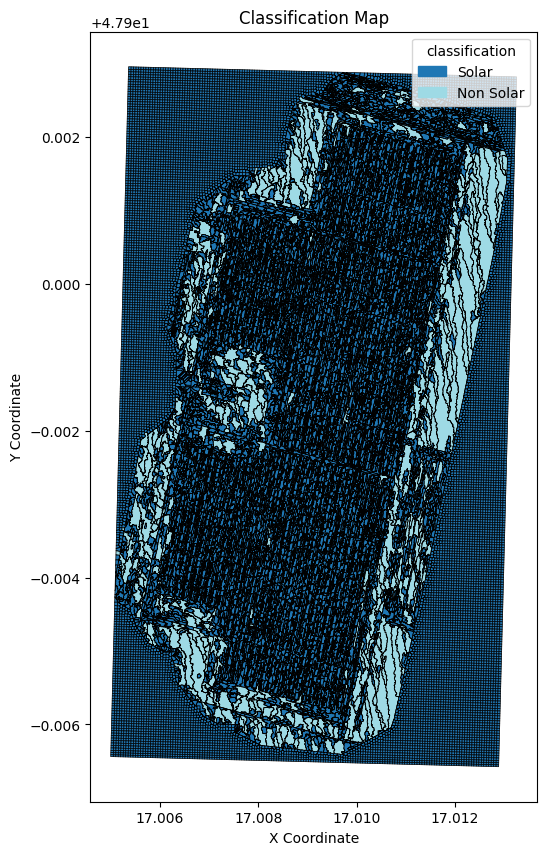

In [11]:
# Direct call
result_layer_SVM, _, _ = run_svm_classification(
    segment_geojson_path="results/segment.geojson",
    samples_json_path="results/samples.json", #you can either pass directly downloaded json or copy-paste the dictionary values inside file below.
    # samples_dict={
    #     "Solar": [1855, 2177, 2448, 3407, 3636, 3733, 3793, 4728,3045, 4748, 4850, 6157, 6337, 4116, 5951, 5590],
    #     "Non-Solar": [7769, 5981, 5899, 3922, 8908, 9619, 1513, 2104, 3961, 2179, 4247, 8643, 2357, 2738, 5192, 6280, 7797, 8122, 8314, 8406, 8489, 8781, 298, 5283, 7449, 8611, 9102, 9353, 9430, 10287, 9809],
    # }
)


In [58]:
#export file
classified_SVM_path = "results/classified_SVM_wgs84.geojson"
export_layer(result_layer_SVM, classified_SVM_path)

Reprojected GeoJSON saved to: results/classified_SVM_wgs84.geojson


### 5.3. KNN

In [12]:
import json
import geopandas as gpd
from nickyspatial.core.layer import Layer, LayerManager
from nickyspatial.core.classifier import SupervisedClassifier
from nickyspatial import plot_classification

def run_knn_classification(
    segment_geojson_path: str,
    samples_json_path: str = None,
    samples_dict: dict = None,
    n_neighbors: int = 5
):
    """
    Perform supervised classification using KNN on segmented data.

    Parameters:
    - segment_geojson_path: str → path to the segmentation GeoJSON
    - samples_json_path: str → path to JSON file with training sample IDs
    - samples_dict: dict → dictionary of manually verified sample segment IDs
    - n_neighbors: int → number of neighbors to use in KNN

    Returns:
    - result_layer: classified layer
    - accuracy: float classification accuracy
    """
    assert samples_json_path or samples_dict, "Provide either samples_json_path or samples_dict"

    # Load GeoJSON
    gdf = gpd.read_file(segment_geojson_path)

    # Load training samples
    if samples_dict is None:
        with open(samples_json_path, "r", encoding="utf-8") as f:
            samples = json.load(f)
    else:
        samples = samples_dict

    # Create segmentation layer
    layer = Layer(name="SegmentLayer", type="segmentation")
    layer.objects = gdf

    # Layer manager
    manager = LayerManager()
    manager.add_layer(layer)

    # KNN classifier
    knn_params = {"n_neighbors": n_neighbors}
    classifier = SupervisedClassifier(
        name="KNN_SolarClassifier",
        classifier_type="KNN",
        classifier_params=knn_params
    )

    # Execute classification
    result_layer, accuracy, feature_importances = classifier.execute(
        source_layer=layer,
        samples=samples,
        layer_manager=manager,
        layer_name="KNN_Classification"
    )

    # Plot results
    fig = plot_classification(result_layer, class_field="classification")
    fig.show()

    # Output
    print("Classification Accuracy:", accuracy)
    print("Feature importances not available for KNN.")

    return result_layer, accuracy


C:\Users\ROG\AppData\Local\Temp\ipykernel_26104\1279947680.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Classification Accuracy: 0.8837209302325582
Feature importances not available for KNN.


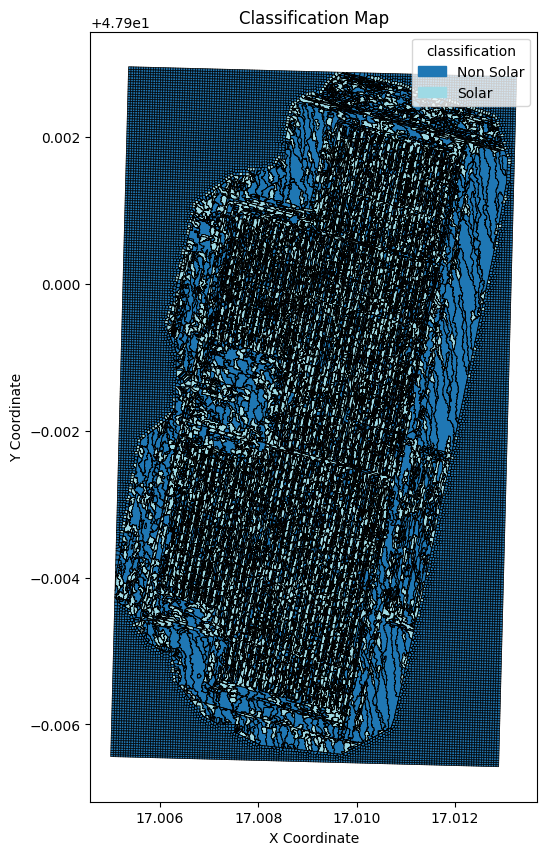

In [14]:
# Run
result_layer_KNN, _ = run_knn_classification(
    segment_geojson_path="results/segment.geojson",
    samples_json_path="results/samples.json",
    # samples_dict={
    #     "Solar": [1855, 2177, 2448, 3407, 3636, 3733, 3793, 4728,3045, 4748, 4850, 6157, 6337, 4116, 5951, 5590],
    #     "Non-Solar": [7769, 5981, 5899, 3922, 8908, 9619, 1513, 2104, 3961, 2179, 4247, 8643, 2357, 2738, 5192, 6280, 7797, 8122, 8314, 8406, 8489, 8781, 298, 5283, 7449, 8611, 9102, 9353, 9430, 10287, 9809],
    # }
    n_neighbors=3
)


In [62]:
#export file
classified_KNN_path = "results/classified_KNN_wgs84.geojson"
export_layer(result_layer_KNN, classified_KNN_path)

Reprojected GeoJSON saved to: results/classified_KNN_wgs84.geojson


## 6. Extract Solar Polygons

In [34]:
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
from nickyspatial.core.layer import Layer
from nickyspatial import plot_classification

def merge_clean_polygons(layer_obj, class_column="classification", target_class="Solar"):
    gdf = layer_obj.objects

    if gdf.empty or class_column not in gdf.columns:
        print(f"Invalid input: empty GeoDataFrame or missing '{class_column}' column.")
        return layer_obj.copy()

    if target_class == "all":
        # --- Merge each class separately ---
        class_values = gdf[class_column].dropna().unique()
        dissolved_list = []

        for cls in class_values:
            class_subset = gdf[gdf[class_column] == cls]
            dissolved = class_subset.dissolve(by=class_column).reset_index()
            dissolved_list.append(dissolved)

        # Combine all classes back together
        final_gdf = pd.concat(dissolved_list, ignore_index=True)

    else:
        # --- Merge only selected target_class ---
        target_gdf = gdf[gdf[class_column] == target_class].copy()
        non_target_gdf = gdf[gdf[class_column] != target_class].copy()

        if target_gdf.empty:
            print(f"No features found for class '{target_class}'.")
            return layer_obj.copy()

        # Merge geometries of target class
        target_union = unary_union(target_gdf.geometry)

        # Remove other geometries that are completely within merged target
        non_target_clean = non_target_gdf[~non_target_gdf.geometry.within(target_union)]

        # Combine
        merged_gdf = gpd.GeoDataFrame(
            pd.concat([target_gdf, non_target_clean], ignore_index=True),
            crs=gdf.crs
        )

        # Dissolve only the target class
        target_dissolved = merged_gdf[merged_gdf[class_column] == target_class].dissolve(by=class_column).reset_index()

        # Combine with other classes
        final_gdf = pd.concat([
            target_dissolved,
            merged_gdf[merged_gdf[class_column] != target_class]
        ], ignore_index=True)

    # --- Create new Layer ---
    new_layer = Layer(name=f"{layer_obj.name}_merged", parent=layer_obj, type=layer_obj.type)
    new_layer.objects = final_gdf
    new_layer.crs = layer_obj.crs
    new_layer.transform = layer_obj.transform
    new_layer.metadata = layer_obj.metadata.copy()

    # --- Plot result ---
    plot_classification(new_layer, class_field=class_column)

    return new_layer


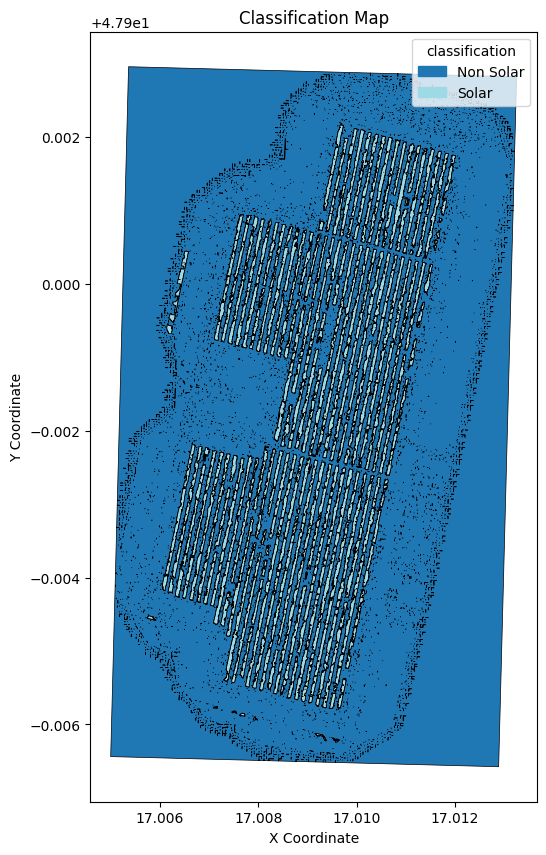

In [36]:
#  Call this using your classified result
solar_layer = merge_clean_polygons(result_layer_RF, class_column="classification", target_class="all")


In [104]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely.validation import make_valid
import geopandas as gpd
import pandas as pd
from nickyspatial.core.layer import Layer
from nickyspatial import plot_classification

def merge_clean_polygons(layer_obj, class_column="classification", target_class="all", area_attr="area_pixels"):
    """
    Merge polygons of the same class while avoiding artifacts and invalid geometries.
    Cleans geometries before creating the final Layer.
    """
    gdf = layer_obj.objects.copy()

    if gdf.empty or class_column not in gdf.columns:
        print(f"Invalid input: empty GeoDataFrame or missing '{class_column}' column.")
        return layer_obj.copy()

    result_rows = []

    if target_class == "all":
        class_values = gdf[class_column].dropna().unique()

        for cls in class_values:
            class_subset = gdf[gdf[class_column] == cls].copy()
            if class_subset.empty:
                continue

            unioned = unary_union(class_subset.geometry)

            if isinstance(unioned, Polygon):
                result_rows.append({"classification": cls, "geometry": Polygon(unioned.exterior)})
            elif isinstance(unioned, MultiPolygon):
                for poly in unioned.geoms:
                    result_rows.append({"classification": cls, "geometry": Polygon(poly.exterior)})

        final_gdf = gpd.GeoDataFrame(result_rows, crs=gdf.crs)

    else:
        target_gdf = gdf[gdf[class_column] == target_class].copy()
        non_target_gdf = gdf[gdf[class_column] != target_class].copy()

        if target_gdf.empty:
            print(f"No features found for class '{target_class}'.")
            return layer_obj.copy()

        unioned = unary_union(target_gdf.geometry)

        cleaned_geoms = []
        if isinstance(unioned, Polygon):
            cleaned_geoms = [Polygon(unioned.exterior)]
        elif isinstance(unioned, MultiPolygon):
            cleaned_geoms = [Polygon(p.exterior) for p in unioned.geoms]

        cleaned_target = gpd.GeoDataFrame({
            class_column: [target_class] * len(cleaned_geoms),
            "geometry": cleaned_geoms
        }, crs=gdf.crs)

        final_gdf = pd.concat([cleaned_target, non_target_gdf], ignore_index=True)

    # Clean geometries and remove invalid ones
    cleaned_geoms = []
    for geom in final_gdf.geometry:
        try:
            if not geom.is_valid:
                geom = make_valid(geom)
            geom = geom.buffer(0)
            if isinstance(geom, (Polygon, MultiPolygon)):
                cleaned_geoms.append(geom)
            else:
                cleaned_geoms.append(None)
        except Exception:
            cleaned_geoms.append(None)

    final_gdf["geometry"] = cleaned_geoms
    final_gdf = final_gdf.dropna(subset=["geometry"])

    if area_attr in gdf.columns:
        final_gdf[area_attr] = final_gdf.geometry.area

    new_layer = Layer(name=f"{layer_obj.name}_merged", parent=layer_obj, type=layer_obj.type)
    new_layer.objects = final_gdf
    new_layer.crs = layer_obj.crs
    new_layer.transform = layer_obj.transform
    new_layer.metadata = layer_obj.metadata.copy()

    try:
        if class_column in final_gdf.columns:
            plot_classification(new_layer, class_field=class_column)
        else:
            new_layer.objects["__dummy__"] = "merged"
            plot_classification(new_layer, class_field="__dummy__")
    except Exception as e:
        print(f"[WARNING] Plotting failed: {e}")

    return new_layer


C:\Users\ROG\AppData\Local\Temp\ipykernel_26104\1401260974.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  final_gdf[area_attr] = final_gdf.geometry.area


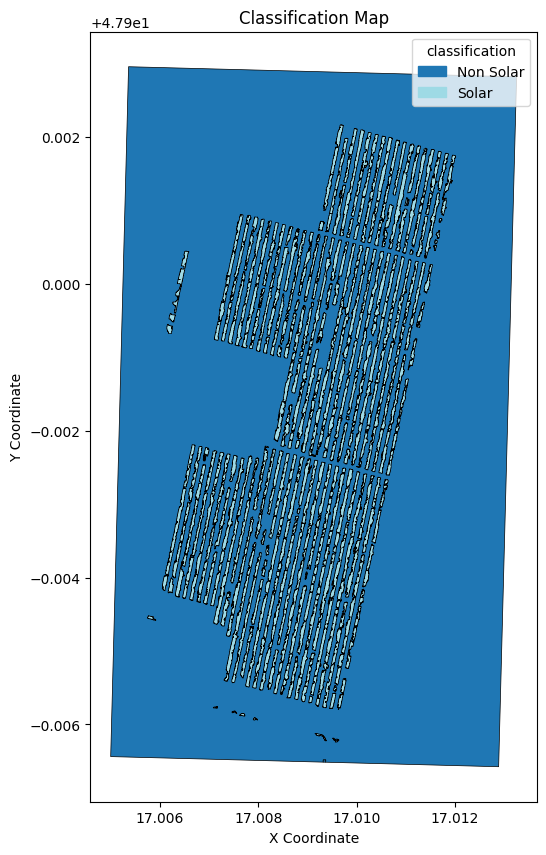

In [105]:
final_solar = merge_clean_polygons(
    layer_obj=result_layer_RF,
    class_column="classification",
    target_class="all",
    area_attr="area_pixels",
)


In [97]:
#export file
solar_path = "results/final_solar.geojson"
export_layer(final_solar, solar_path)

Reprojected GeoJSON saved to: results/final_solar.geojson


## 7. Downsample Raster
If the raster is very big it might fail because of memory error. Downsample if memory error is faced.

In [49]:
import rasterio
from rasterio.enums import Resampling

def downsample_raster(input_path, output_path, factor):
    """
    Downsample a raster by a given factor and save to a new file.
    
    Parameters:
        input_path (str): Path to the input orthophoto.
        output_path (str): Path where the downsampled raster will be saved.
        factor (int or float): Downsampling factor. E.g., 4 means image becomes 1/4 the size.
    """
    with rasterio.open(input_path) as src:
        # Calculate new dimensions
        new_width = int(src.width / factor)
        new_height = int(src.height / factor)

        # Read data with new shape
        data = src.read(
            out_shape=(
                src.count,
                new_height,
                new_width
            ),
            resampling=Resampling.bilinear
        )

        # Scale the transform accordingly
        transform = src.transform * src.transform.scale(
            src.width / new_width,
            src.height / new_height
        )

        # Write to output
        profile = src.profile
        profile.update({
            'height': new_height,
            'width': new_width,
            'transform': transform
        })

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data)
            print("saved file")


In [50]:
# Example usage:
downsample_raster(
    input_path="ortho/solar_pv_True_Ortho.tif",
    output_path="ortho/solar_pv_True_Ortho_downsampled.tif",
    factor=7  # Change as needed
)

saved file
